In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import chi2, VarianceThreshold

from sklearn.preprocessing import OrdinalEncoder


pd.options.display.max_columns = None

/tmp/ipykernel_428371/2082368134.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
boston = pd.read_csv(
    r"/home/ahmed/Ai/Kaggle-Competitions-Notebooks/boston House price prediction/Date_set/train.csv"
)
test = pd.read_csv(
    r"/home/ahmed/Ai/Kaggle-Competitions-Notebooks/boston House price prediction/Date_set/test.csv"
)
combin = [boston, test]

# Feature Transforming


## 1. Removing Redundant Features


In [3]:
boston.shape, test.shape

((1460, 81), (1459, 80))

##### 1.1. Remove columns with high missing values


In [4]:
uneeded_columns = []

for column in boston.columns:
    percentage = boston[column].isna().sum() * 100 / len(boston)
    if percentage > 30:
        uneeded_columns.append([column, percentage])

uneeded_columns

[['Alley', 93.76712328767124],
 ['MasVnrType', 59.726027397260275],
 ['FireplaceQu', 47.26027397260274],
 ['PoolQC', 99.52054794520548],
 ['Fence', 80.75342465753425],
 ['MiscFeature', 96.3013698630137]]

##### i will remove those columns from both data sets


In [5]:
drop = []
for i, j in uneeded_columns:
    drop.append(i)

for dataset in combin:
    dataset.drop(columns=drop, axis=1, inplace=True)

boston.shape, test.shape

((1460, 75), (1459, 74))

## 2. Handling massing values


In [6]:
null_num_columns = []
null_cat_columns = []

for column in boston.columns:
    percentage = boston[column].isna().sum() * 100 / len(boston)
    if percentage > 0:
        if boston[column].dtype != "O":
            null_num_columns.append([column, percentage])
        else:
            null_cat_columns.append([column, percentage])

print(null_num_columns, "\n")
print(null_cat_columns)

[['LotFrontage', 17.73972602739726], ['MasVnrArea', 0.547945205479452], ['GarageYrBlt', 5.5479452054794525]] 

[['BsmtQual', 2.5342465753424657], ['BsmtCond', 2.5342465753424657], ['BsmtExposure', 2.6027397260273974], ['BsmtFinType1', 2.5342465753424657], ['BsmtFinType2', 2.6027397260273974], ['Electrical', 0.0684931506849315], ['GarageType', 5.5479452054794525], ['GarageFinish', 5.5479452054794525], ['GarageQual', 5.5479452054794525], ['GarageCond', 5.5479452054794525]]


In [7]:
num_columns = []
cat_columns = []
for i, j in null_num_columns:
    num_columns.append(i)

for i, j in null_cat_columns:
    cat_columns.append(i)


print(num_columns)
print()
print(cat_columns)

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']


##### Stratege:

if the missing values in the column less than 3%, so i will fill it with mean (for numerical) or mode (for categorical)

otherwise, i will use linear models or decision tree to fill the missing values


##### 2.1. Numerical values (boston data set)


In [8]:
def fill_numerical_values_with_linear_model(dataset, column):

    data = dataset[[column, "SalePrice"]].copy()
    data[column] = data[column].fillna(-1)
    train = data[data[column] != -1]
    missied_data = pd.DataFrame(data[data[column] == -1]["SalePrice"])

    x_train, x_test, y_train, y_test = train_test_split(
        train.drop(columns=column, axis=1),
        train[column],
        train_size=0.01,
        random_state=42,
    )

    lin_reg = LinearRegression()
    lin_reg.fit(x_train, y_train)
    predction = list(lin_reg.predict(missied_data))

    def update(value):
        if value == -1:
            ret = int(predction[0])
            predction.pop(0)
            return ret
        return value

    dataset[column] = dataset[column].fillna(-1)
    dataset[column] = dataset[column].apply(update)

    return dataset[column]


def fill_numerical_values_with_mean(dataset=pd.DataFrame(), column=str):

    mean = dataset[column].mean()
    dataset[column] = dataset[column].fillna(mean)
    return dataset[column]


for column in num_columns:
    percentage = boston[column].isna().sum() * 100 / len(boston)

    if percentage <= 3:  # with mean
        boston[column] = fill_numerical_values_with_mean(boston, column)

    else:  # with model
        boston[column] = fill_numerical_values_with_linear_model(boston, column)

##### 2.2. Categorical values (boston data set)


In [9]:
def fill_numerical_values_with_RF_model(dataset, column):
    data = dataset[[column, "SalePrice"]].copy()
    data[column] = data[column].fillna("missied_data")
    train = data[data[column] != "missied_data"]
    missied_data = pd.DataFrame(data[data[column] == "missied_data"]["SalePrice"])

    x_train, x_test, y_train, y_test = train_test_split(
        train.drop(columns=column, axis=1),
        train[column],
        train_size=0.01,
        random_state=42,
    )

    RF = RandomForestClassifier(ccp_alpha=0.015)
    RF.fit(x_train, y_train)
    predction = list(RF.predict(missied_data))

    def update(value):
        if value == "missied_data":
            ret = predction[0]
            predction.pop(0)
            return ret
        return value

    dataset[column] = dataset[column].fillna("missied_data")
    dataset[column] = dataset[column].apply(update)

    return dataset[column]


def fill_numerical_values_with_mode(dataset, column):
    mode = dataset[column].mode()[0]
    dataset[column] = dataset[column].fillna(mode)
    return dataset[column]


for column in cat_columns:
    percentage = boston[column].isna().sum() * 100 / len(boston)

    if percentage <= 3:  # with mean
        boston[column] = fill_numerical_values_with_mode(boston, column)

    else:  # with model
        boston[column] = fill_numerical_values_with_RF_model(boston, column)

##### 2.3. Now lets fill data in test dataset


In [10]:
null_num_columns = []
null_cat_columns = []

for column in test.columns:
    percentage = test[column].isna().sum() * 100 / len(test)
    if percentage > 0:
        if test[column].dtype != "O":
            null_num_columns.append([column, percentage])
        else:
            null_cat_columns.append([column, percentage])

print(null_num_columns, "\n")
print(null_cat_columns)

[['LotFrontage', 15.558601782042494], ['MasVnrArea', 1.0281014393420151], ['BsmtFinSF1', 0.06854009595613433], ['BsmtFinSF2', 0.06854009595613433], ['BsmtUnfSF', 0.06854009595613433], ['TotalBsmtSF', 0.06854009595613433], ['BsmtFullBath', 0.13708019191226867], ['BsmtHalfBath', 0.13708019191226867], ['GarageYrBlt', 5.346127484578479], ['GarageCars', 0.06854009595613433], ['GarageArea', 0.06854009595613433]] 

[['MSZoning', 0.27416038382453733], ['Utilities', 0.13708019191226867], ['Exterior1st', 0.06854009595613433], ['Exterior2nd', 0.06854009595613433], ['BsmtQual', 3.015764222069911], ['BsmtCond', 3.0843043180260454], ['BsmtExposure', 3.015764222069911], ['BsmtFinType1', 2.8786840301576424], ['BsmtFinType2', 2.8786840301576424], ['KitchenQual', 0.06854009595613433], ['Functional', 0.13708019191226867], ['GarageType', 5.2090472926662095], ['GarageFinish', 5.346127484578479], ['GarageQual', 5.346127484578479], ['GarageCond', 5.346127484578479], ['SaleType', 0.06854009595613433]]


##### All columns has missing values with low percentage, so i will fill them with mean and mode


In [11]:
num_columns = []
cat_columns = []
for i, j in null_num_columns:
    num_columns.append(i)

for i, j in null_cat_columns:
    cat_columns.append(i)


print(num_columns)
print()
print(cat_columns)

['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']

['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'SaleType']


In [12]:
for column in cat_columns:
    test[column] = fill_numerical_values_with_mode(test, column)

for column in num_columns:
    test[column] = fill_numerical_values_with_mean(test, column)

In [13]:
boston.shape, test.shape

((1460, 75), (1459, 74))

## 3. Outliers


In [14]:
numirical_columns = []

for col in boston.columns:
    if boston[col].dtype != "O":
        numirical_columns.append(col)
numirical_columns.remove("SalePrice")
len(numirical_columns)

37

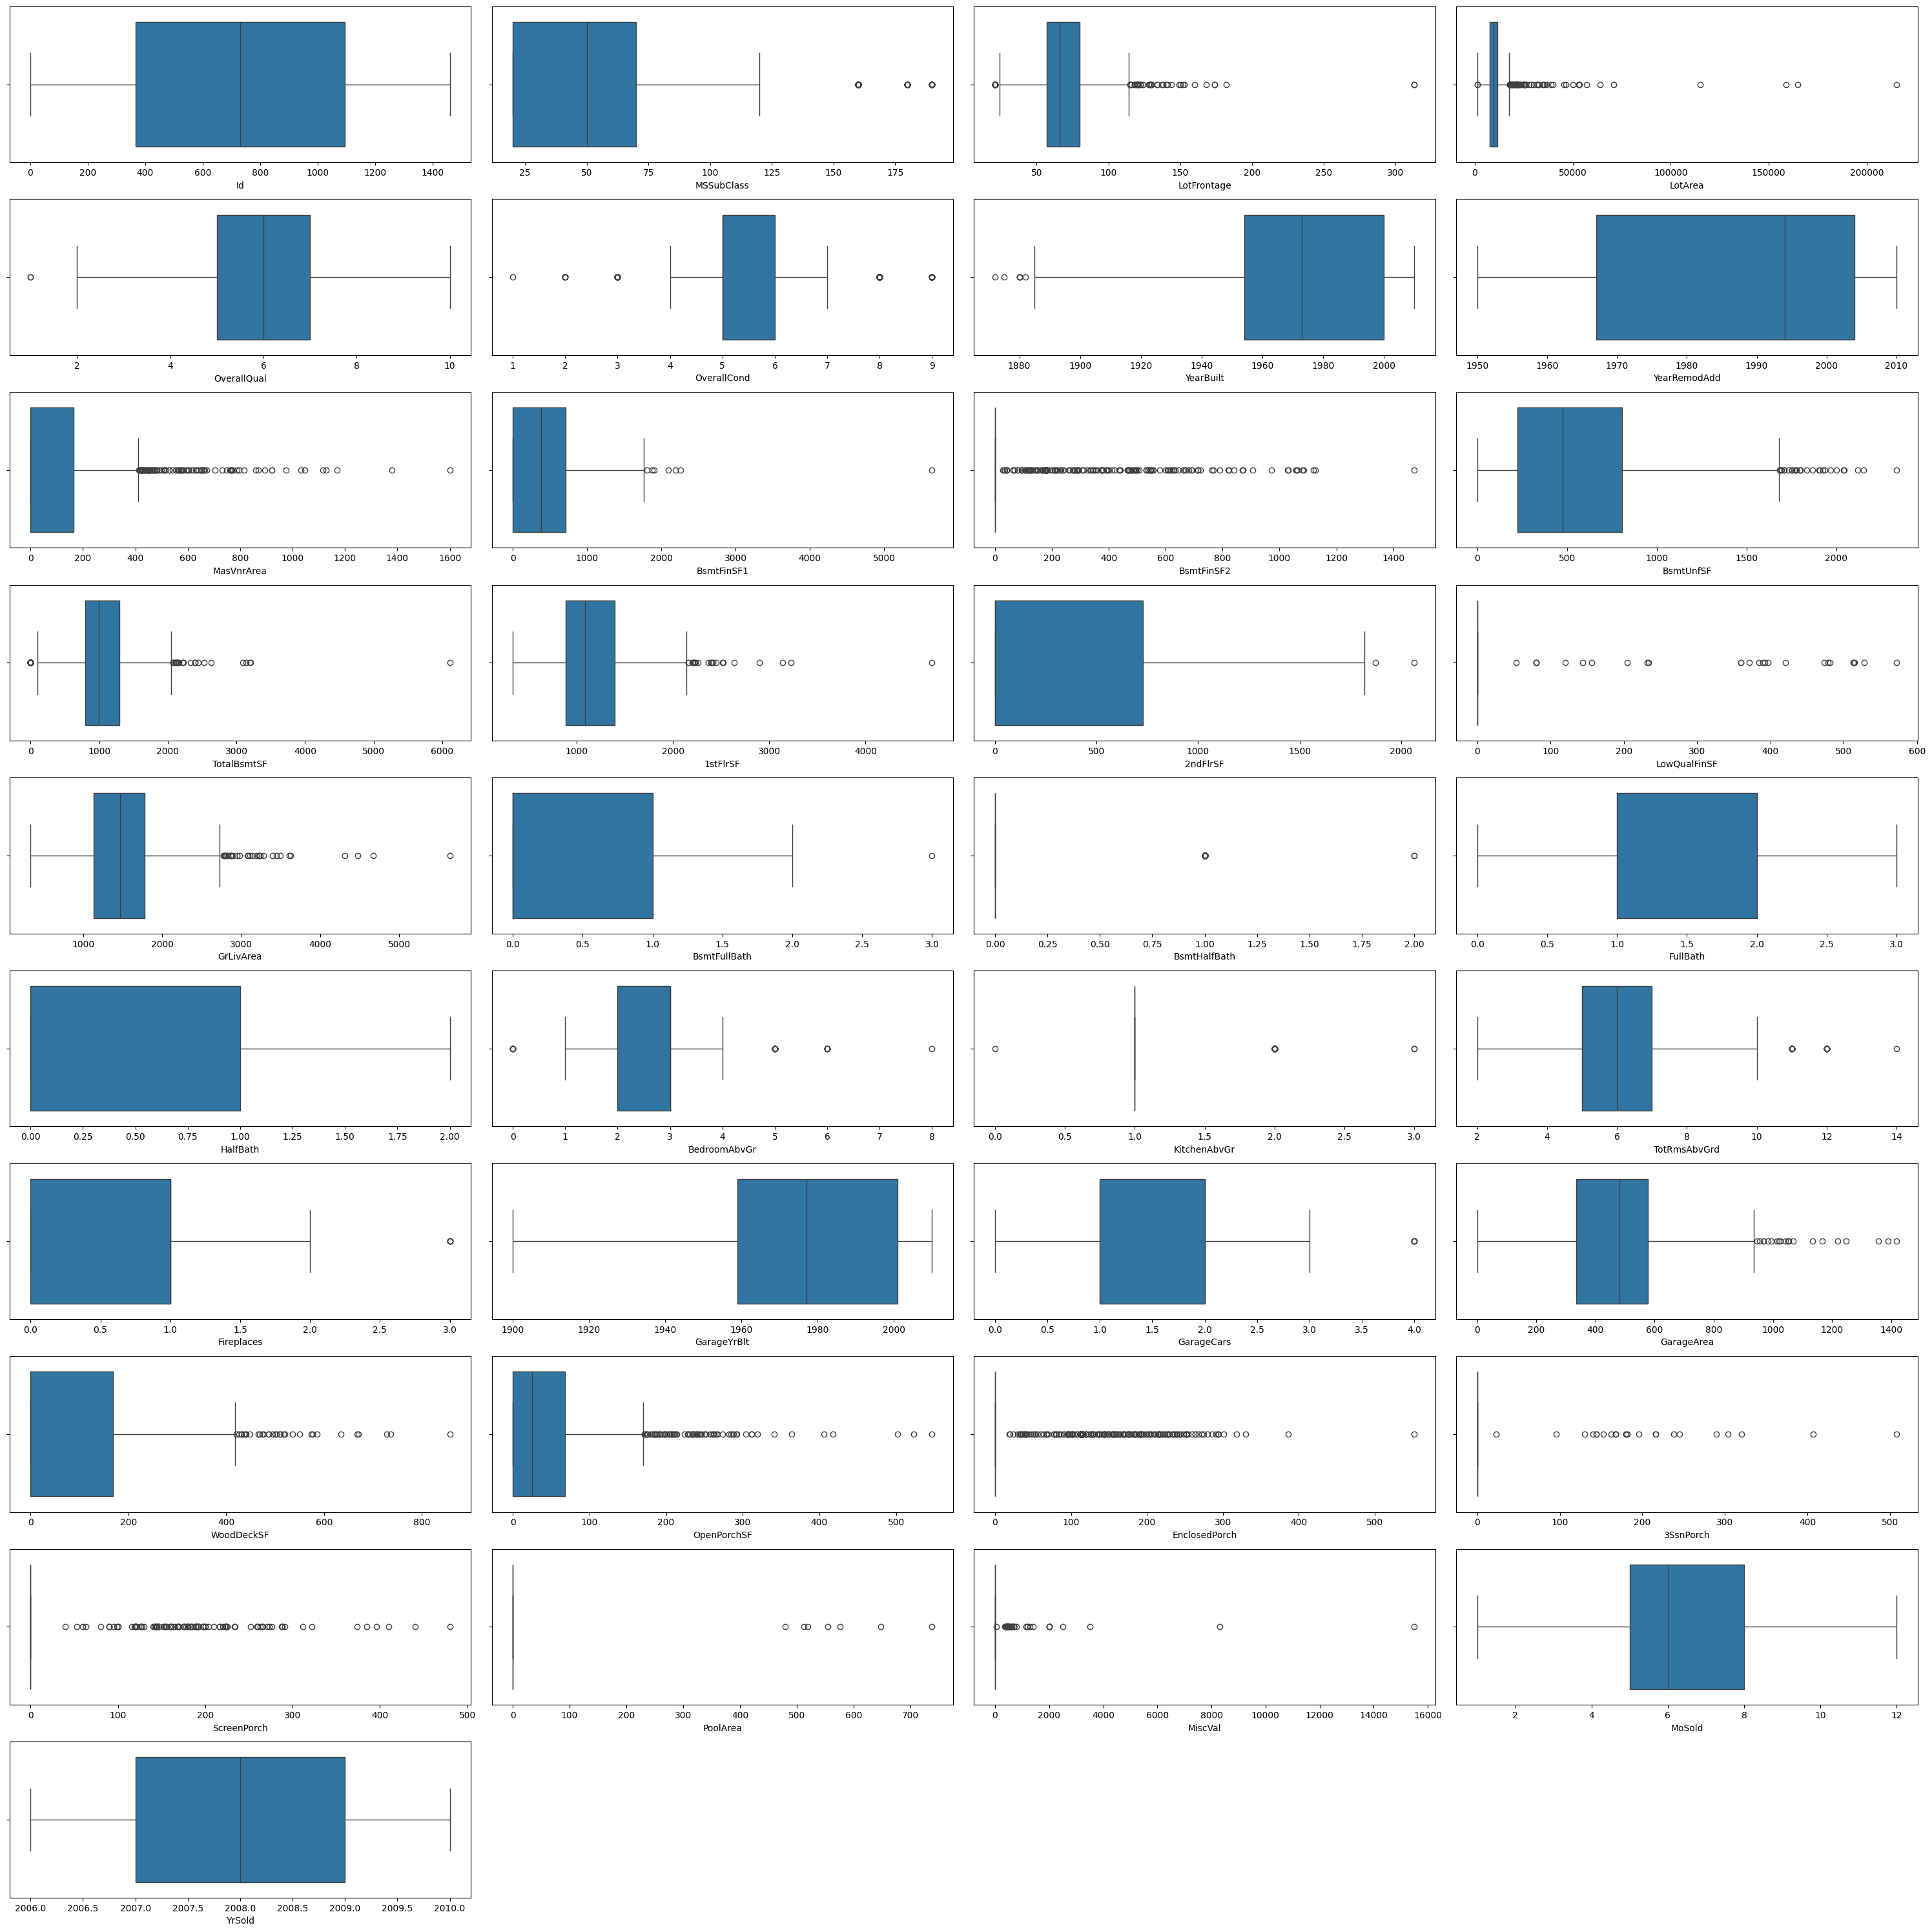

In [15]:
# fig, axs = plt.subplots(8, 5, figsize=(14, 15))
fig = plt.figure(figsize=(30, 30))

for j, i in enumerate(numirical_columns):
    plt.subplot(10, 4, j + 1)

    sns.boxplot(data=boston, x=i)
fig.tight_layout(pad=1.0)

plt.show()

##### i will remove outliers from

    ["LotFrontage", "LotArea", "BsmtFinSF1", "TotalBsmtSF", "GrLivArea"]


##### and from box plot above i will construct new columns, Totalarea, TotalBsmtFin, TotalSF, TotalBath, TotalPorch


In [16]:
boston.shape

(1460, 75)

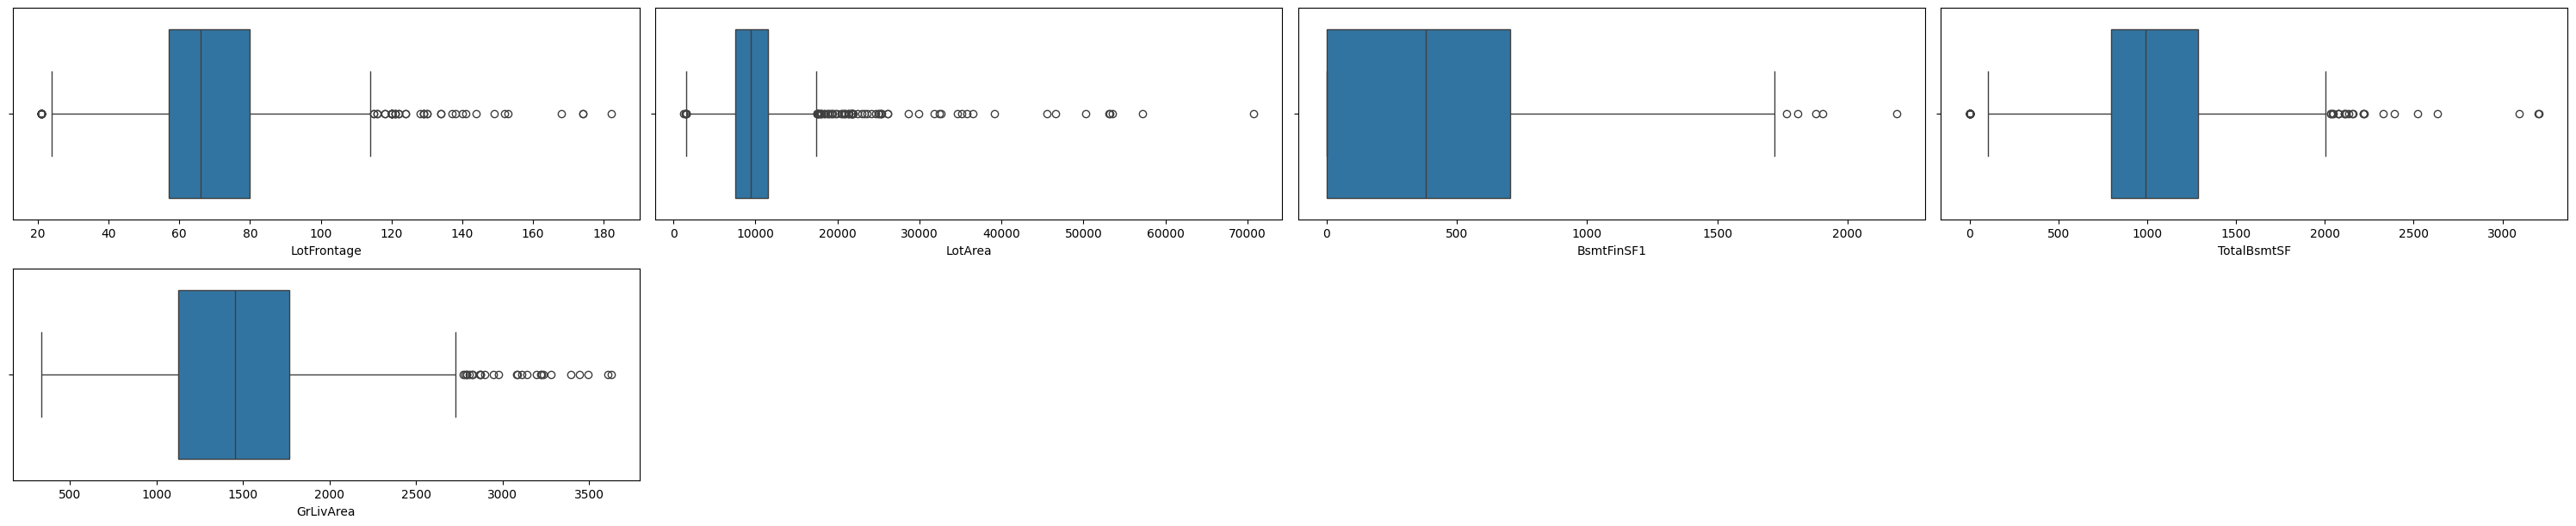

In [17]:
outliers_col = ["LotFrontage", "LotArea", "BsmtFinSF1", "TotalBsmtSF", "GrLivArea"]

boston = boston.drop(boston[boston["LotFrontage"] > 185].index)
boston = boston.drop(boston[boston["LotArea"] > 100000].index)
boston = boston.drop(boston[boston["BsmtFinSF1"] > 4000].index)
boston = boston.drop(boston[boston["TotalBsmtSF"] > 5000].index)
boston = boston.drop(boston[boston["GrLivArea"] > 4000].index)

fig = plt.figure(figsize=(30, 30))

for j, i in enumerate(outliers_col):
    plt.subplot(10, 4, j + 1)

    sns.boxplot(data=boston, x=i)
fig.tight_layout(pad=1.0)

plt.show()

In [18]:
boston.shape

(1451, 75)

# Feature Construction


In [19]:
combin = [boston, test]

for dataset in combin:
    dataset["Totalarea"] = dataset["LotArea"] + dataset["LotFrontage"]
    dataset["TotalBsmtFin"] = dataset["BsmtFinSF1"] + dataset["BsmtFinSF2"]
    dataset["TotalSF"] = dataset["TotalBsmtSF"] + dataset["2ndFlrSF"]
    dataset["TotalBath"] = dataset["FullBath"] + dataset["HalfBath"]
    dataset["TotalPorch"] = (
        dataset["ScreenPorch"] + dataset["EnclosedPorch"] + dataset["OpenPorchSF"]
    )

## convert them to Binay Columns


In [20]:
def update(val):
    if val > 0:
        return 1
    return 0


for dataset in combin:
    dataset["Totalarea"] = dataset["Totalarea"].apply(update)
    dataset["TotalBsmtFin"] = dataset["TotalBsmtFin"].apply(update)
    dataset["TotalSF"] = dataset["TotalSF"].apply(update)
    dataset["TotalBath"] = dataset["TotalBath"].apply(update)
    dataset["TotalPorch"] = dataset["Totalarea"].apply(update)

# Feature Selection


In [21]:
removed_columns = set()
numirical_columns = []
categorical_columns = []

for col in boston.columns:
    if boston[col].dtype != "O":
        numirical_columns.append(col)
    else:
        categorical_columns.append(col)

numirical_columns.remove("SalePrice")

## 1. VarianceThreshold for numercal columns

for constant columns or columns with low variance (that has more than 80% of the samples)


In [22]:
presntage = 0.8 * (1 - 0.8)
X = boston[numirical_columns]
var = VarianceThreshold(threshold=presntage)
var.fit(X)

VarianceThreshold(threshold=0.15999999999999998)

In [23]:
boolean_selection = var.get_support()
columns_names = var.feature_names_in_

In [24]:
for i in range(len(boolean_selection)):
    if boolean_selection[i] == False:
        removed_columns.add(columns_names[i])

removed_columns

{'BsmtHalfBath',
 'KitchenAbvGr',
 'TotalBath',
 'TotalPorch',
 'TotalSF',
 'Totalarea'}

## 2. Correlations


<Axes: >

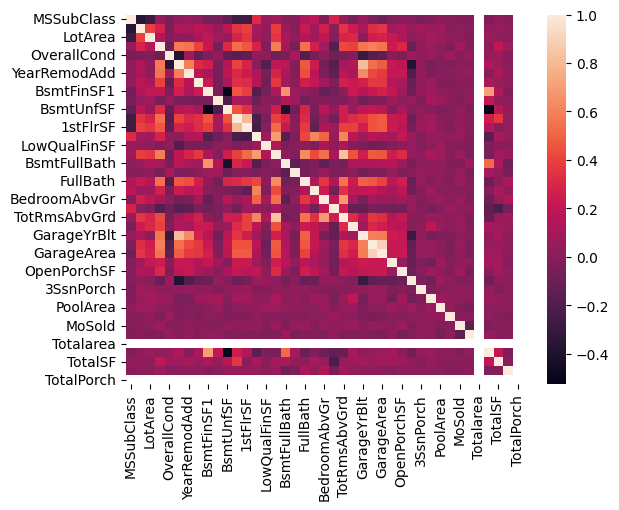

In [25]:
df = boston[numirical_columns].drop(columns=["Id"], axis=1)

corr = df.corr()

sns.heatmap(corr)

In [26]:
def remove_strong_corr(data_set, neg_corr, pos_corr):
    global removed_columns
    correlation = data_set.corr()

    for i in range(len(correlation.columns)):

        for j in range(i):
            corr_value = correlation.iloc[i, j]

            if corr_value < 0 and corr_value < neg_corr:
                print(correlation.columns[j], correlation.columns[i])
                removed_columns.add(correlation.columns[j])
            elif corr_value > 0 and corr_value > pos_corr:
                print(correlation.columns[j], correlation.columns[i])
                removed_columns.add(correlation.columns[j])

    return


remove_strong_corr(df, neg_corr=-0.4, pos_corr=0.8)
print(len(removed_columns))
print(removed_columns)

BsmtFinSF1 BsmtUnfSF
TotalBsmtSF 1stFlrSF
BsmtUnfSF BsmtFullBath
GrLivArea TotRmsAbvGrd
YearBuilt GarageYrBlt
GarageCars GarageArea
BsmtUnfSF TotalBsmtFin
12
{'TotalSF', 'BsmtHalfBath', 'GrLivArea', 'TotalPorch', 'Totalarea', 'GarageCars', 'KitchenAbvGr', 'YearBuilt', 'TotalBsmtSF', 'TotalBath', 'BsmtFinSF1', 'BsmtUnfSF'}


In [27]:
removed_columns.remove("GrLivArea")
removed_columns

{'BsmtFinSF1',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'GarageCars',
 'KitchenAbvGr',
 'TotalBath',
 'TotalBsmtSF',
 'TotalPorch',
 'TotalSF',
 'Totalarea',
 'YearBuilt'}

## 3. Chi2

for categorical columns


In [28]:
df = boston[categorical_columns]
df

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,TA,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,Plywood,Plywood,TA,TA,CBlock,Gd,TA,No,ALQ,Rec,GasA,TA,Y,SBrkr,TA,Min1,Attchd,Unf,TA,TA,Y,WD,Normal
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,CemntBd,CmentBd,Ex,Gd,Stone,TA,Gd,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,TA,TA,CBlock,TA,TA,Mn,GLQ,Rec,GasA,Gd,Y,FuseA,Gd,Typ,Attchd,Unf,TA,TA,Y,WD,Normal


In [29]:
df.nunique()

MSZoning          5
Street            2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          7
Exterior1st      15
Exterior2nd      16
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
SaleType          9
SaleCondition     6
dtype: int64

In [30]:
ord = OrdinalEncoder()
ord.fit(df)
df[df.columns] = ord.transform(df)
df

/tmp/ipykernel_428371/1290922739.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df.columns] = ord.transform(df)


,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,3.0,1.0,3.0,3.0,0.0,4.0,0.0,5.0,2.0,2.0,0.0,5.0,1.0,0.0,12.0,13.0,2.0,4.0,2.0,2.0,3.0,3.0,2.0,5.0,1.0,0.0,1.0,4.0,2.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
1,3.0,1.0,3.0,3.0,0.0,2.0,0.0,24.0,1.0,2.0,0.0,2.0,1.0,0.0,8.0,8.0,3.0,4.0,1.0,2.0,3.0,1.0,0.0,5.0,1.0,0.0,1.0,4.0,3.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
2,3.0,1.0,0.0,3.0,0.0,4.0,0.0,5.0,2.0,2.0,0.0,5.0,1.0,0.0,12.0,13.0,2.0,4.0,2.0,2.0,3.0,2.0,2.0,5.0,1.0,0.0,1.0,4.0,2.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
3,3.0,1.0,0.0,3.0,0.0,0.0,0.0,6.0,2.0,2.0,0.0,5.0,1.0,0.0,13.0,15.0,3.0,4.0,0.0,3.0,1.0,3.0,0.0,5.0,1.0,2.0,1.0,4.0,2.0,6.0,5.0,2.0,4.0,4.0,2.0,8.0,0.0
4,3.0,1.0,0.0,3.0,0.0,2.0,0.0,15.0,2.0,2.0,0.0,5.0,1.0,0.0,12.0,13.0,2.0,4.0,2.0,2.0,3.0,0.0,2.0,5.0,1.0,0.0,1.0,4.0,2.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,3.0,1.0,3.0,3.0,0.0,4.0,0.0,8.0,2.0,2.0,0.0,5.0,1.0,0.0,12.0,13.0,3.0,4.0,2.0,2.0,3.0,3.0,5.0,5.0,1.0,0.0,1.0,4.0,3.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
1456,3.0,1.0,3.0,3.0,0.0,4.0,0.0,14.0,2.0,2.0,0.0,2.0,1.0,0.0,9.0,10.0,3.0,4.0,1.0,2.0,3.0,3.0,0.0,4.0,1.0,4.0,1.0,4.0,3.0,2.0,1.0,2.0,4.0,4.0,2.0,8.0,4.0
1457,3.0,1.0,3.0,3.0,0.0,4.0,0.0,6.0,2.0,2.0,0.0,5.0,1.0,0.0,5.0,5.0,0.0,2.0,4.0,3.0,1.0,3.0,2.0,5.0,1.0,0.0,1.0,4.0,2.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
1458,3.0,1.0,3.0,3.0,0.0,4.0,0.0,12.0,2.0,2.0,0.0,2.0,3.0,0.0,8.0,8.0,3.0,4.0,1.0,3.0,3.0,2.0,2.0,4.0,1.0,2.0,1.0,0.0,2.0,6.0,1.0,2.0,4.0,4.0,2.0,8.0,4.0


In [31]:
X = df
Y = boston["SalePrice"]

chi_state, p_value = chi2(X, Y)

needed_column = 0
column_names = []
columns = list(X.columns)


for i in range(len(p_value)):
    if p_value[i] <= 0.05:
        needed_column += 1
        column_names.append(columns[i])
        removed_columns.add(columns[i])

print("all columns = ", len(p_value))
print("needed column = ", needed_column)
print("the columns i will take : ", column_names)
print("number of removed columns :", len(removed_columns))
print("removed columns are :", removed_columns)

all columns =  37
needed column =  10
the columns i will take :  ['LotShape', 'LandSlope', 'Neighborhood', 'BldgType', 'HouseStyle', 'RoofMatl', 'Exterior2nd', 'BsmtFinType1', 'HeatingQC', 'GarageType']
number of removed columns : 21
removed columns are : {'Totalarea', 'KitchenAbvGr', 'BsmtFinSF1', 'BsmtHalfBath', 'GarageCars', 'Exterior2nd', 'BsmtUnfSF', 'HouseStyle', 'Neighborhood', 'HeatingQC', 'YearBuilt', 'TotalBath', 'RoofMatl', 'GarageType', 'TotalSF', 'LotShape', 'TotalPorch', 'BldgType', 'TotalBsmtSF', 'BsmtFinType1', 'LandSlope'}


## 5. VarianceThreshold for categorical columns

for constant columns or columns with low variance (that has more than 80% of the samples)


In [32]:
presntage = 0.8 * (1 - 0.8)
X = df
var = VarianceThreshold(threshold=presntage)
var.fit(X)

VarianceThreshold(threshold=0.15999999999999998)

In [33]:
boolean_selection = var.get_support()
columns_names = var.feature_names_in_
print(boolean_selection)
print()
print(columns_names)

[ True False  True  True False  True False  True  True False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True False  True  True  True  True  True  True  True  True  True
  True]

['MSZoning' 'Street' 'LotShape' 'LandContour' 'Utilities' 'LotConfig'
 'LandSlope' 'Neighborhood' 'Condition1' 'Condition2' 'BldgType'
 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st' 'Exterior2nd'
 'ExterQual' 'ExterCond' 'Foundation' 'BsmtQual' 'BsmtCond' 'BsmtExposure'
 'BsmtFinType1' 'BsmtFinType2' 'Heating' 'HeatingQC' 'CentralAir'
 'Electrical' 'KitchenQual' 'Functional' 'GarageType' 'GarageFinish'
 'GarageQual' 'GarageCond' 'PavedDrive' 'SaleType' 'SaleCondition']


In [34]:
for i in range(len(boolean_selection)):
    if boolean_selection[i] == False:
        removed_columns.add(columns_names[i])

print(len(removed_columns))
print((removed_columns))

26
{'Condition2', 'Utilities', 'Totalarea', 'KitchenAbvGr', 'CentralAir', 'BsmtFinSF1', 'Heating', 'BsmtHalfBath', 'GarageCars', 'Exterior2nd', 'BsmtUnfSF', 'HouseStyle', 'Neighborhood', 'HeatingQC', 'YearBuilt', 'TotalBath', 'RoofMatl', 'GarageType', 'Street', 'TotalSF', 'LotShape', 'TotalPorch', 'BldgType', 'TotalBsmtSF', 'BsmtFinType1', 'LandSlope'}


## 6. remove columns that have same value more than 95 %


In [35]:
for col in boston.columns:
    count = boston[col].value_counts().sort_values(ascending=False)
    top_value_count = count.iloc[0]
    if top_value_count * 100 / len(boston) > 85:
        removed_columns.add(col)

print(len(removed_columns))
print()
print((removed_columns))

44

{'ExterCond', 'Condition2', 'GarageCond', 'Utilities', 'Totalarea', 'MiscVal', 'KitchenAbvGr', 'CentralAir', 'BsmtFinSF1', 'PavedDrive', 'Heating', 'BsmtHalfBath', 'GarageQual', 'BsmtFinSF2', 'GarageCars', 'ScreenPorch', 'Exterior2nd', 'EnclosedPorch', 'BsmtUnfSF', 'HouseStyle', 'Neighborhood', 'Condition1', 'Functional', 'BsmtFinType2', 'HeatingQC', 'YearBuilt', 'Electrical', 'TotalBath', 'RoofMatl', 'BsmtCond', 'LandContour', 'GarageType', 'Street', 'TotalSF', 'LotShape', 'TotalPorch', '3SsnPorch', 'BldgType', 'TotalBsmtSF', 'BsmtFinType1', 'LowQualFinSF', 'SaleType', 'PoolArea', 'LandSlope'}


In [36]:
removed_columns.remove("TotalBath")
removed_columns.remove("TotalSF")
removed_columns.remove("TotalBsmtSF")
removed_columns.remove("TotalPorch")
removed_columns.remove("Totalarea")


combin = [boston, test]


for dataset in combin:
    dataset.drop(columns=list(removed_columns), axis=1, inplace=True)
boston.shape, test.shape

((1451, 41), (1459, 40))

# log SalePrice to fix skew


In [37]:
boston["SalePrice"].skew()

1.5803037060213119

<Axes: xlabel='SalePrice', ylabel='Count'>

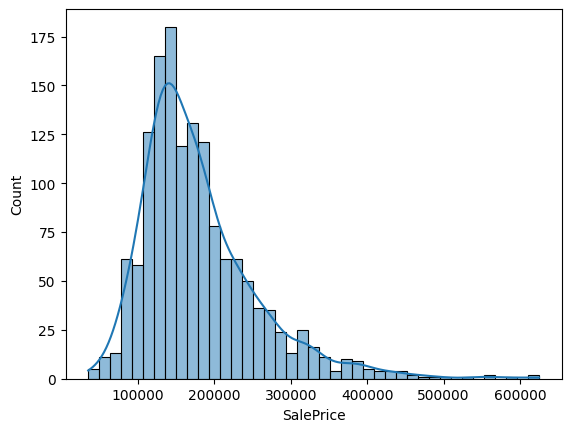

In [38]:
sns.histplot(boston["SalePrice"], kde=True)

<Axes: xlabel='SalePrice', ylabel='Count'>

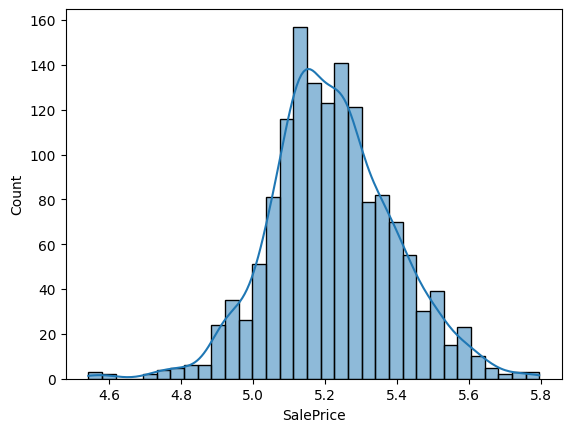

In [39]:
sns.histplot(np.log10(boston["SalePrice"]), kde=True)

In [40]:
print(
    boston["SalePrice"].skew(),
    " ",
    boston["SalePrice"].mean(),
    " ",
    boston["SalePrice"].std(),
)

1.5803037060213119   179789.96967608546   76520.25028690192


In [41]:
boston["SalePrice"] = np.log10(boston["SalePrice"])

# Dummy dataset


In [42]:
boston = pd.get_dummies(boston, drop_first=True)
boston.head(2)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,SalePrice,Totalarea,TotalBsmtFin,TotalSF,TotalBath,TotalPorch,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,GarageFinish_RFn,GarageFinish_Unf,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,196.0,856,856,854,1710,1,2,1,3,8,0,2003.0,548,0,61,2,2008,5.319106,1,1,1,1,1,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,True,False,True,False,True,False,False,False,False,True,False
1,2,20,80.0,9600,6,8,1976,0.0,1262,1262,0,1262,0,2,0,3,6,1,1976.0,460,298,0,5,2007,5.258877,1,1,1,1,1,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,True,False,False,False,False,True,True,False,False,False,False,True,False


In [43]:
test = pd.get_dummies(test, drop_first=True)
test.head(2)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,Totalarea,TotalBsmtFin,TotalSF,TotalBath,TotalPorch,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,GarageFinish_RFn,GarageFinish_Unf,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,80.0,11622,5,6,1961,0.0,882.0,896,0,896,0.0,1,0,2,5,0,1961.0,730.0,140,0,6,2010,1,1,1,1,1,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,True,False,False,True,False,True,False,False,False,True,False
1,1462,20,81.0,14267,6,6,1958,108.0,1329.0,1329,0,1329,0.0,1,1,3,6,0,1958.0,312.0,393,36,6,2010,1,1,1,1,1,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False,False,False,False,False,False,True,False,False,True,False,True,False,False,True,False,False,False,True,False


In [44]:
boston.shape, test.shape

((1451, 81), (1459, 78))

In [45]:
mp = {}

for i in boston.columns:
    if i in mp:
        mp[i] += 1
    else:
        mp[i] = 1
for i in test.columns:
    if i in mp:
        mp[i] += 1
    else:
        mp[i] = 1

for i, j in mp.items():
    if j != 2:
        print(i)

SalePrice
Exterior1st_ImStucc
Exterior1st_Stone


In [46]:
test["Exterior1st_ImStucc"] = False
test["Exterior1st_Stone"] = False

In [47]:
boston.shape, test.shape

((1451, 81), (1459, 80))

In [48]:
final_test = pd.DataFrame()
for col in boston.columns:
    if col != "SalePrice":
        final_test[col] = test[col]
test = final_test

In [49]:
for col in boston.columns:
    if boston[col].dtype == "bool":
        boston[col] = boston[col].astype("int32")

for col in test.columns:
    if test[col].dtype == "bool":
        test[col] = test[col].astype("int32")

In [50]:
boston

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,SalePrice,Totalarea,TotalBsmtFin,TotalSF,TotalBath,TotalPorch,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,GarageFinish_RFn,GarageFinish_Unf,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,196.0,856,856,854,1710,1,2,1,3,8,0,2003.0,548,0,61,2,2008,5.319106,1,1,1,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,0.0,1262,1262,0,1262,0,2,0,3,6,1,1976.0,460,298,0,5,2007,5.258877,1,1,1,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2002,162.0,920,920,866,1786,1,2,1,3,6,1,2001.0,608,0,42,9,2008,5.349278,1,1,1,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1970,0.0,756,961,756,1717,1,1,0,3,7,1,1998.0,642,0,35,2,2006,5.146128,1,1,1,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,350.0,1145,1145,1053,2198,1,2,1,4,9,1,2000.0,836,192,84,12,2008,5.397940,1,1,1,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,2000,0.0,953,953,694,1647,0,2,1,3,7,1,1999.0,460,0,40,8,2007,5.243038,1,0,1,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,1,0
1456,1457,20,85.0,13175,6,6,1988,119.0,1542,2073,0,2073,1,2,0,3,7,2,1978.0,500,349,0,2,2010,5.322219,1,1,1,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0
1457,1458,70,66.0,9042,7,9,2006,0.0,1152,1188,1152,2340,0,2,0,4,9,2,1941.0,252,0,60,5,2010,5.425697,1,1,1,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0
1458,1459,20,68.0,9717,5,6,1996,0.0,1078,1078,0,1078,1,1,0,2,5,0,1950.0,240,366,0,4,2010,5.152670,1,1,1,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0


In [51]:
test

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,Totalarea,TotalBsmtFin,TotalSF,TotalBath,TotalPorch,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,GarageFinish_RFn,GarageFinish_Unf,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,80.0,11622,5,6,1961,0.0,882.0,896,0,896,0.0,1,0,2,5,0,1961.000000,730.0,140,0,6,2010,1,1,1,1,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0
1,1462,20,81.0,14267,6,6,1958,108.0,1329.0,1329,0,1329,0.0,1,1,3,6,0,1958.000000,312.0,393,36,6,2010,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0
2,1463,60,74.0,13830,5,5,1998,0.0,928.0,928,701,1629,0.0,2,1,3,6,1,1997.000000,482.0,212,34,3,2010,1,1,1,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0
3,1464,60,78.0,9978,6,6,1998,20.0,926.0,926,678,1604,0.0,2,1,3,7,1,1998.000000,470.0,360,36,6,2010,1,1,1,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0
4,1465,120,43.0,5005,8,5,1992,0.0,1280.0,1280,0,1280,0.0,2,0,2,5,0,1992.000000,506.0,0,82,1,2010,1,1,1,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,21.0,1936,4,7,1970,0.0,546.0,546,546,1092,0.0,1,1,3,5,0,1977.721217,0.0,0,0,6,2006,1,0,1,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0
1455,2916,160,21.0,1894,4,5,1970,0.0,546.0,546,546,1092,0.0,1,1,3,6,0,1970.000000,286.0,0,24,4,2006,1,1,1,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0
1456,2917,20,160.0,20000,5,7,1996,0.0,1224.0,1224,0,1224,1.0,1,0,4,7,1,1960.000000,576.0,474,0,9,2006,1,1,1,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0
1457,2918,85,62.0,10441,5,5,1992,0.0,912.0,970,0,970,0.0,1,0,3,6,0,1977.721217,0.0,80,32,7,2006,1,1,1,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0


In [52]:
boston.to_csv(
    r"/home/ahmed/Ai/Kaggle-Competitions-Notebooks/boston House price prediction/TransformedDataset/train.csv"
)
test.to_csv(
    r"/home/ahmed/Ai/Kaggle-Competitions-Notebooks/boston House price prediction/TransformedDataset/test.csv"
)